# Dressed Levels at slices through QuaDiSQ point

This notebook calculates the dressed energy levels of the two-qubit transmon system for the parameters on horizontal and vertical slices marked by "x" in Fig 1,2 in the paper.

In [1]:
import QDYN
import qutip
import numpy as np
from scipy.sparse import find as find_nonzero
from qnet.algebra import LocalSpace
import matplotlib.pylab as plt
from mgplottools.io import writetotxt

In [2]:
from model_v2 import transmon_model, state as bare_state

In [3]:
%load_ext autoreload
%autoreload 2

The bare parameters at point "X" are as follows:

In [4]:
w1     = 6000.0 # MHz
w2     = 5900.0 # MHz
wc     = 6200.0 # MHz
wd     = 0 # 5932.5 # MHz  # 0 means no RWA
alpha1 = -290.0 # MHz
alpha2 = -310.0 # MHz
g      =   70.0 # MHz
n_qubit = 5
n_cavity = 6
kappa = 0.0
gamma = 0.0
alpha = 0.5 * abs(alpha1 + alpha2)

In [5]:
zero_pulse = QDYN.pulse.Pulse(QDYN.pulse.pulse_tgrid(50, 2000), time_unit='ns', ampl_unit='MHz')

In [6]:
hs = (LocalSpace('q1', dimension=n_qubit, order_index=1) *
      LocalSpace('q2', dimension=n_qubit, order_index=2) *
      LocalSpace('c', dimension=n_cavity, order_index=3))

## Definitions

In [7]:
def vert_x_slice(x):
    """parametrization by x of vertical slice through point X"""
    # wc = 6200 # from global
    w2 = x * alpha + w1
    return (w2, wc)

In [8]:
def horiz_x_slice(x):
    """parametrization by x of horizontal slice through point X"""
    # w2 = 5900 # from global
    wc = x * g + w1
    return (w2, wc)

In [9]:
def energy_curves_point(x, func_w2_wc):
    """return dressed energy values E_01, E_10, E_11, E_20, E_02, and E_c
    for a bare fixed w1 and w2, wc determined by func_w2_wc(x)"""
    w2, wc = func_w2_wc(x)
    model = transmon_model(
        n_qubit, n_cavity, w1, w2, wc, wd, alpha1, alpha2, g, gamma, kappa,
        lambda_a=1.0, pulse=zero_pulse, dissipation_model='non-Hermitian')
    H0 = model.ham()[0]
    eigvals, eigvecs = H0.eigenstates()
    # normalize eigvecs to that real part of largest value is positive
    for (i_v, vec) in enumerate(eigvecs):
        val = find_nonzero(vec.data)[2]
        if val[np.argmax(np.abs(val))].real < 0:
            eigvecs[i_v] = -1 * eigvecs[i_v]
    bare_states = [
        bare_state(hs, 0, 1, 0), bare_state(hs, 1, 0, 0),
        bare_state(hs, 1, 1, 0), bare_state(hs, 0, 0, 1),
        bare_state(hs, 2, 0, 0), bare_state(hs, 0, 2, 0)]
    dressed_levels = []
    for state in bare_states:
        f_overlap = lambda i, v: 0 if i in dressed_levels else state.overlap(v)
        dressed_levels.append(
            np.argmax([abs(f_overlap(i, v)) for (i, v) in enumerate(eigvecs)]))
    ind010, ind100, ind110, ind001, ind200, ind020 = dressed_levels
    E_01 = eigvals[ind010]; E_10 = eigvals[ind100]; E_11 = eigvals[ind110]
    E_20 = eigvals[ind200]; E_02 = eigvals[ind020]; E_c = eigvals[ind001]
    return E_01, E_10, E_11, E_20, E_02, E_c

In [10]:
def energy_curves(x_s, func_w2_wc):
    """Collect results from `energy_curves_point` for each value x in x_s
    into arrays of dressed energy values"""
    E_01_s, E_10_s, E_11_s, E_20_s, E_02_s, E_c_s = [], [], [], [], [], []
    for x in x_s:
        E_01, E_10, E_11, E_20, E_02, E_c = energy_curves_point(x, func_w2_wc)
        E_01_s.append(E_01); E_10_s.append(E_10); E_11_s.append(E_11)
        E_20_s.append(E_20); E_02_s.append(E_02); E_c_s.append(E_c)
    return (
        np.array(x_s),
        np.array(E_01_s), np.array(E_10_s), np.array(E_11_s),
        np.array(E_20_s), np.array(E_02_s), np.array(E_c_s))

In [11]:
def plot_energy_curves(
        ax, x_s, E_01_s, E_10_s, E_11_s, E_20_s, E_02_s, E_c_s):
    """Plot absolute dressed energies, from which zeta can be read off"""
    ax.plot(x_s, E_01_s + E_10_s, label='$E_{01}+E_{10}$')
    ax.plot(x_s, E_11_s, label='$E_{11}$')
    #ax.plot(x_s, E_20_s, label='$E_{20}$')
    #ax.plot(x_s, E_02_s, label='$E_{02}$')
    ax.legend()
    ax.set_ylabel("Energy (MHz)")
    ax.set_xlabel("x (dimensionless)")
    ax.grid()
    ax.set_title("Dressed Energy Levels")

In [12]:
def plot_energy_curves_single(
        ax, x_s, E_01_s, E_10_s, E_11_s, E_20_s, E_02_s, E_c_s):
    """Plot absolute dressed energies"""
    ax.plot(x_s, E_01_s, label=r'$E_{01}$')
    ax.plot(x_s, E_10_s, label=r'$E_{10}$')
    ax.legend()
    ax.set_ylabel("Energy (MHz)")
    ax.grid()

In [13]:
def plot_delta_curves(
        ax, x_s, E_01_s, E_10_s, E_11_s, E_20_s, E_02_s, E_c_s, w1_s, w2_s, wc_s):
    """Plot relative dressed energies, from which zeta can be read off"""
    ax.plot(x_s, E_01_s + E_10_s - w1_s - w2_s, label='$\Delta E_{01}+\Delta E_{10}$')
    ax.plot(x_s, E_11_s - w1_s - w2_s, label='$\Delta E_{11}$')
    ax.legend()
    ax.set_ylabel("Energy (MHz)")
    ax.set_xlabel("x (dimensionless)")
    ax.grid()

In [14]:
def plot_delta_curves_single(
        ax, x_s, E_01_s, E_10_s, E_11_s, E_20_s, E_02_s, E_c_s, w1_s, w2_s, wc_s):
    """Plot relative dressed energies"""
    ax.plot(x_s, E_01_s - w2_s, label=r'$\Delta E_{01}$')
    ax.plot(x_s, E_10_s - w1_s, label=r'$\Delta E_{10}$')
    ax.plot(x_s, E_c_s - wc_s, label=r'$\Delta E_{001}$')
    #ax.plot(x_s, E_20_s - 2 * w1_s - alpha1, label='$\Delta E_{20}$')
    #ax.plot(x_s, E_02_s - 2 * w2_s - alpha2, label='$\Delta E_{02}$')
    ax.legend(loc='upper right')
    ax.set_ylabel("Energy (MHz)")
    ax.grid()

## Plots

### horizontal slice

In [15]:
x_s = np.linspace(-10, 10, 100)
data_horiz = energy_curves(x_s, horiz_x_slice)
w1_horiz = np.array([w1 for x in x_s])
w2_horiz = np.array([w2 for x in x_s])
wc_horiz = np.array([wc for wc in horiz_x_slice(x_s)[1]])

writetotxt(
    "dressed_levels_horiz_slice.dat",
    *data_horiz, w1_horiz, w2_horiz, wc_horiz,
    header=(("%25s" * 10) %
        ('x [dimensionless]', 'E_01 [MHz]', 'E_10 [MHz]', 'E_11 [MHz]',
         'E_20 [MHz]', 'E_02 [MHz]', 'E_cav [MHz]', 'w1 [MHz]', 'w2 [MHz]',
         'wc [MHz]')))

absolute dressed levels:

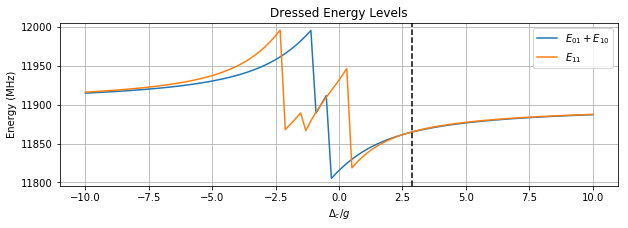

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_energy_curves(ax, *data_horiz)
ax.set_xlabel('$\Delta_c/g$')
ax.axvline(x=((wc-w1)/g), ls='dashed', color='black')
plt.show(fig)

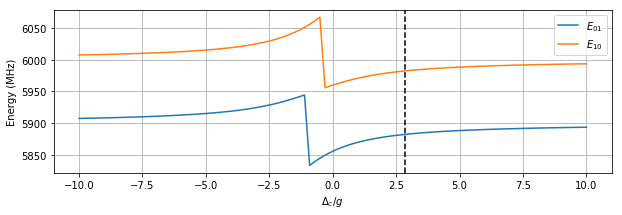

In [17]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_energy_curves_single(ax, *data_horiz)
ax.set_xlabel(r'$\Delta_c/g$')
ax.axvline(x=((wc-w1)/g), ls='dashed', color='black')
plt.show(fig)

dressed levels relative to bare levels:

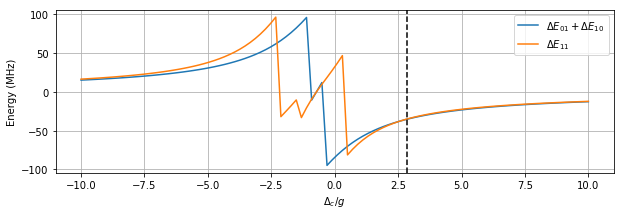

In [18]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_delta_curves(ax, *data_horiz, w1_horiz, w2_horiz, wc_horiz)
ax.set_xlabel('$\Delta_c/g$')
ax.axvline(x=((wc-w1)/g), ls='dashed', color='black')
plt.show(fig)

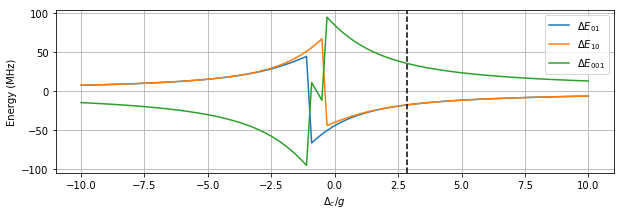

In [19]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_delta_curves_single(ax, *data_horiz, w1_horiz, w2_horiz, wc_horiz)
ax.set_xlabel(r'$\Delta_c/g$')
ax.axvline(x=((wc-w1)/g), ls='dashed', color='black')
plt.show(fig)

### vertical slice

In [20]:
x_s = np.linspace(-3, 3, 100)
data_vert = energy_curves(x_s, vert_x_slice)
w1_vert = np.array([w1 for x in x_s])
w2_vert = np.array([w2 for w2 in vert_x_slice(x_s)[0]])
wc_vert = np.array([wc for x in x_s])

writetotxt(
    "dressed_levels_vert_slice.dat",
    *data_vert, w1_vert, w2_vert, wc_vert,
    header=(("%25s" * 10) %
        ('x [dimensionless]', 'E_01 [MHz]', 'E_10 [MHz]', 'E_11 [MHz]',
         'E_20 [MHz]', 'E_02 [MHz]', 'E_cav [MHz]', 'w1 [MHz]', 'w2 [MHz]',
         'wc [MHz]')))

absolute dressed levels:

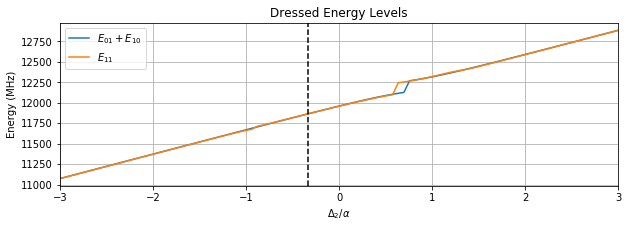

In [21]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_energy_curves(ax, *data_vert)
ax.set_xlabel(r'$\Delta_2/\alpha$')
ax.axvline(x=((w2-w1)/alpha), ls='dashed', color='black')
ax.set_xlim(-3, 3)
#ax.set_ylim(11500, 12500)
plt.show(fig)

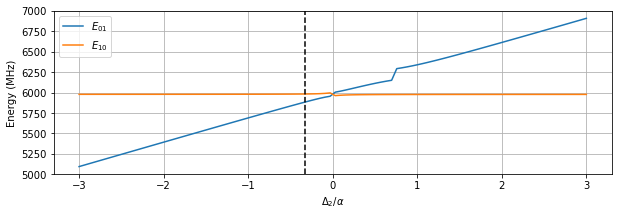

In [22]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_energy_curves_single(ax, *data_vert)
ax.set_xlabel(r'$\Delta_2/\alpha$')
ax.axvline(x=((w2-w1)/alpha), ls='dashed', color='black')
plt.show(fig)

dressed levels relative to bare levels:

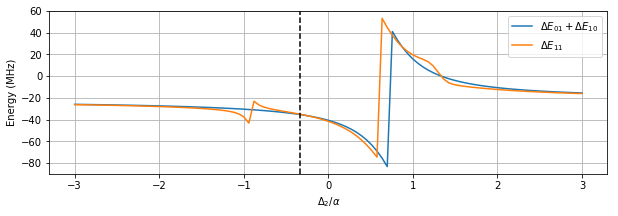

In [23]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_delta_curves(ax, *data_vert, w1_vert, w2_vert, wc_vert)
ax.set_xlabel(r'$\Delta_2/\alpha$')
ax.axvline(x=((w2-w1)/alpha), ls='dashed', color='black')
#ax.set_xlim(-1, 1)
plt.show(fig)

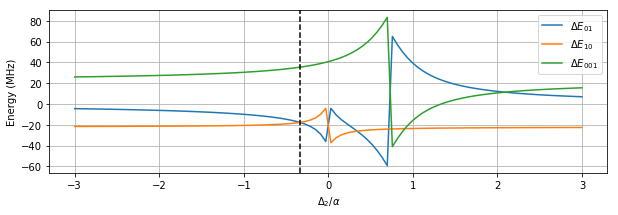

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_delta_curves_single(ax, *data_vert, w1_vert, w2_vert, wc_vert)
ax.set_xlabel(r'$\Delta_2/\alpha$')
ax.axvline(x=((w2-w1)/alpha), ls='dashed', color='black')
plt.show(fig)